# Embeddings
This notebook is used for display the embedding space with UMAP, and resarch some feature from it

In [1]:
%pip install umap-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from umap import UMAP
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json

In [3]:
joint_emb = '/work/cvcs2024/SLR_sentiment_enhanced/SLRSE_model_data/Retrival/Embeddings/embeddings_w_labels_27_2/joint_embeddings.pt'
joint_motion_emb = '/work/cvcs2024/SLR_sentiment_enhanced/SLRSE_model_data/Retrival/Embeddings/embeddings_w_labels_27_2/joint_motion_embeddings.pt'
bone_emb = '/work/cvcs2024/SLR_sentiment_enhanced/SLRSE_model_data/Retrival/Embeddings/embeddings_w_labels_27_2/bone_embeddings.pt'
bone_motion_emb = '/work/cvcs2024/SLR_sentiment_enhanced/SLRSE_model_data/Retrival/Embeddings/embeddings_w_labels_27_2/bone_motion_embeddings.pt'

## Joint space

In [37]:
data = torch.load(joint_emb, map_location=torch.device('cpu'))
embedding_space = data['embeddings']

labels = []
tensor_data = []
# save label and tensor
for k in embedding_space.keys():
    l, vec = embedding_space[k].values()
    labels.append(l)
    tensor_data.append(vec)


In [38]:
# we need to convert to numpy data with shape (#_of_sample, 256)

np_data = np.array([t.numpy() for t in tensor_data]).squeeze(1)
np_data.shape

(10878, 256)

In [39]:
umap_2d = UMAP(n_components=2, min_dist=0.99, metric='cosine')

proj_2d = umap_2d.fit_transform(np_data)

In [40]:
# try to display where the emotion label are 
EMOTION_LABEL_PATH = "/homes/nrossi/code/SLR_Sentiment_Enhanced/DAN_module/sign_emotion_assosiation.json"
labels_names = ['neutral','happy', 'sad', 'surprise', 'fear', 'disgust', 'anger', 'contempt']

f_w_to_e = open(EMOTION_LABEL_PATH)
w_to_e = json.load(f_w_to_e)

raw_label = {}
for k, i in w_to_e.items():
    print(k,i)
    raw_label[labels_names[int(k)]] = i

1 [62, 157, 1118, 1511, 1855]
2 [111, 175, 317, 327, 698, 1157, 1367, 1699, 1277]
3 [1004, 769, 1299]
4 [692, 1291, 441, 628]
5 [484, 492, 1373]
6 [637, 1897, 794]
7 [309, 81]


In [41]:
# save emotion labels and size of the points 
emotion_labels = []
for l in labels:
    for k,v in raw_label.items():
        flag = False
        if int(l) in v:
            emotion_labels.append(k)
            flag = True
            break
    if not flag:
        emotion_labels.append('neutral')

size_p = []
for label,vec in zip(emotion_labels,proj_2d):
    if label != 'neutral':
        size_p.append(40)
    else:
        size_p.append(3)

/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


<Figure size 1500x500 with 0 Axes>

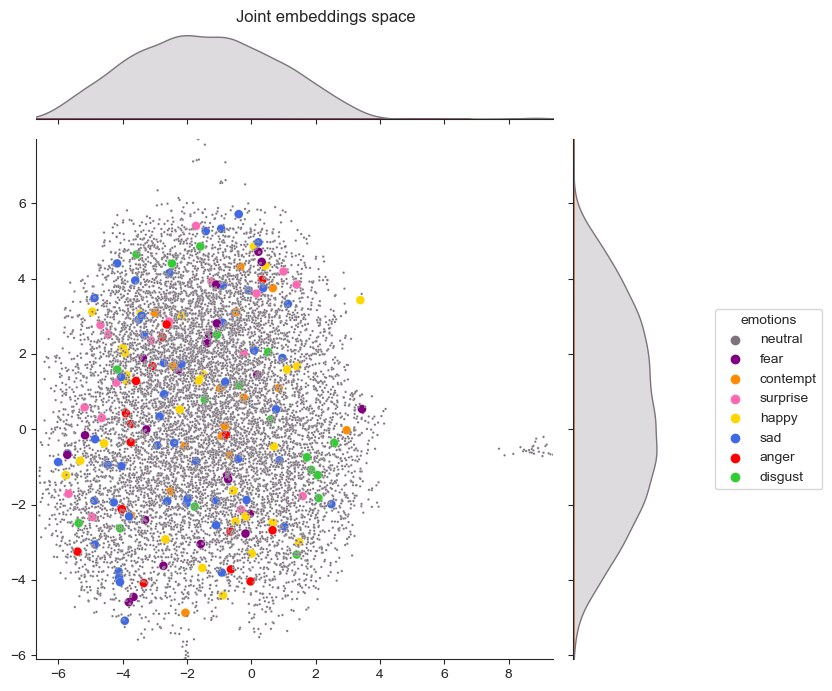

In [42]:
emotion_color_map = {
    'neutral': '#7C737D',  # Grigio chiaro
    'happy': '#FFD700',    # Oro
    'sad': '#4169E1',      # Blu reale
    'surprise': '#FF69B4', # Rosa caldo
    'fear': '#800080',     # Viola
    'disgust': '#32CD32',  # Verde lime
    'anger': '#FF0000',    # Rosso
    'contempt': '#FF8C00'  # Arancione scuro
}

# Funzione per creare jointplot
def create_jointplot(data, metadata, title, scatter_size=10,legend=False, color_map=None):
    sns.set_style("ticks")
    jp = sns.jointplot(
        x=data[:,0], 
        y=data[:,1],
        data=data, 
        hue=metadata, 
        palette=color_map,
        height=7, 
        marginal_kws=dict(fill=True),
        joint_kws={'s': scatter_size},
        legend=legend
    )
    jp.figure.suptitle(title)
    jp.figure.tight_layout()
    jp.ax_joint.set_xlim(proj_2d[:,0].min(),proj_2d[:,0].max())
    jp.ax_joint.set_ylim(proj_2d[:,1].min(),proj_2d[:,1].max())
    jp.figure.subplots_adjust(top=0.95)  # Adatta il titolo

    
    
    # Rimuovere i nomi degli assi
    jp.set_axis_labels('', '')
    # Sposta la legenda fuori dal grafico
    jp.ax_joint.legend(loc='center left', bbox_to_anchor=(1.3, 0.5), title='emotions')
    return jp

# Creare la visualizzazione UMAP
plt.figure(figsize=(15, 5))
joint_plot = create_jointplot(proj_2d, emotion_labels, 'Joint embeddings space', scatter_size=size_p, legend=labels_names[1:], color_map=emotion_color_map)

# Salva il plot come file PNG

joint_plot.savefig('./imgs/plot_umap_joint_emotion_cosine.png', bbox_inches='tight')

# Mostra il plot
plt.show()

In [6]:
# create the tsv file for vector 
with open('joint_embeddings.tsv', 'w') as f:
    for row in np_data:
        # convert number in string 
        row_s = '\t'.join(map(str, row))
        f.write(row_s + '\n')

print('tsv created')

tsv created


In [34]:
# create tsv for metadata
gloss_list_path = "/work/cvcs2024/SLR_sentiment_enhanced/datasets/WLASL/WLASL/start_kit/gloss_list.csv"

df = pd.read_csv(gloss_list_path).to_dict()

df['gloss'][1]

'drink'

In [36]:
# create tsv for metadata
gloss_list_path = "/work/cvcs2024/SLR_sentiment_enhanced/datasets/WLASL/WLASL/start_kit/gloss_list.csv"

df = pd.read_csv(gloss_list_path)
keys = embedding_space.keys()
keys = list(keys)

with open('joint_metadata_2.tsv', 'w') as f:
    f.write('Sample\tGloss\n')
    for key in keys:
        l = embedding_space[key]['label']
        gloss = df['gloss'][int(l)]
        f.write(f'{key}\t{gloss} \n')

print('tsv created')

tsv created


In [36]:
umap_2d = UMAP(n_components=2, min_dist=0.3, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(np_data)



/homes/nrossi/.local/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


numpy.ndarray

<AxesSubplot:>

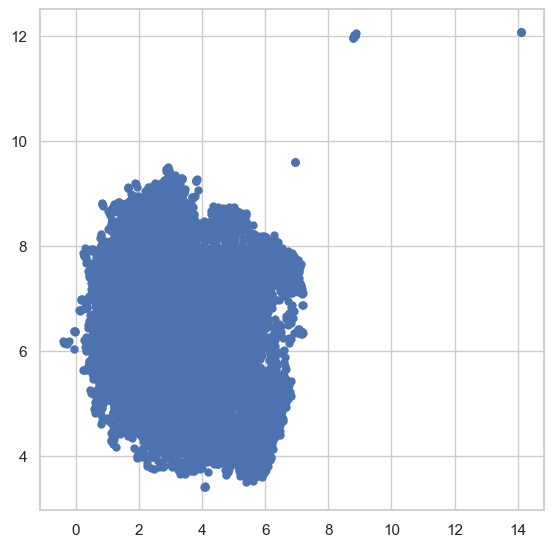

In [43]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.set_theme(style="whitegrid")
sns.scatterplot(x=proj_2d[:,0], y=proj_2d[:,1],
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=embedding_space, ax=ax)

# Bone  space

In [4]:
data = torch.load(bone_emb, map_location=torch.device('cpu'))
embedding_space = data['embeddings']

labels = []
tensor_data = []
# save label and tensor
for k in embedding_space.keys():
    l, vec = embedding_space[k].values()
    labels.append(l)
    tensor_data.append(vec)

In [5]:
# we need to convert to numpy data with shape (#_of_sample, 256)

np_data = np.array([t.numpy() for t in tensor_data]).squeeze(1)
np_data.shape

(10878, 256)

In [6]:
umap_2d = UMAP(n_components=2, min_dist=0.99, metric='cosine')

proj_2d = umap_2d.fit_transform(np_data)

In [7]:
# try to display where the emotion label are 
EMOTION_LABEL_PATH = "/homes/nrossi/code/SLR_Sentiment_Enhanced/DAN_module/sign_emotion_assosiation.json"
labels_names = ['neutral','happy', 'sad', 'surprise', 'fear', 'disgust', 'anger', 'contempt']

f_w_to_e = open(EMOTION_LABEL_PATH)
w_to_e = json.load(f_w_to_e)

raw_label = {}
for k, i in w_to_e.items():
    print(k,i)
    raw_label[labels_names[int(k)]] = i

1 [62, 157, 1118, 1511, 1855]
2 [111, 175, 317, 327, 698, 1157, 1367, 1699, 1277]
3 [1004, 769, 1299]
4 [692, 1291, 441, 628]
5 [484, 492, 1373]
6 [637, 1897, 794]
7 [309, 81]


In [8]:
# save emotion labels and size of the points 
emotion_labels = []
for l in labels:
    for k,v in raw_label.items():
        flag = False
        if int(l) in v:
            emotion_labels.append(k)
            flag = True
            break
    if not flag:
        emotion_labels.append('neutral')

size_p = []
for label,vec in zip(emotion_labels,proj_2d):
    if label != 'neutral':
        size_p.append(40)
    else:
        size_p.append(3)


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


<Figure size 1500x500 with 0 Axes>

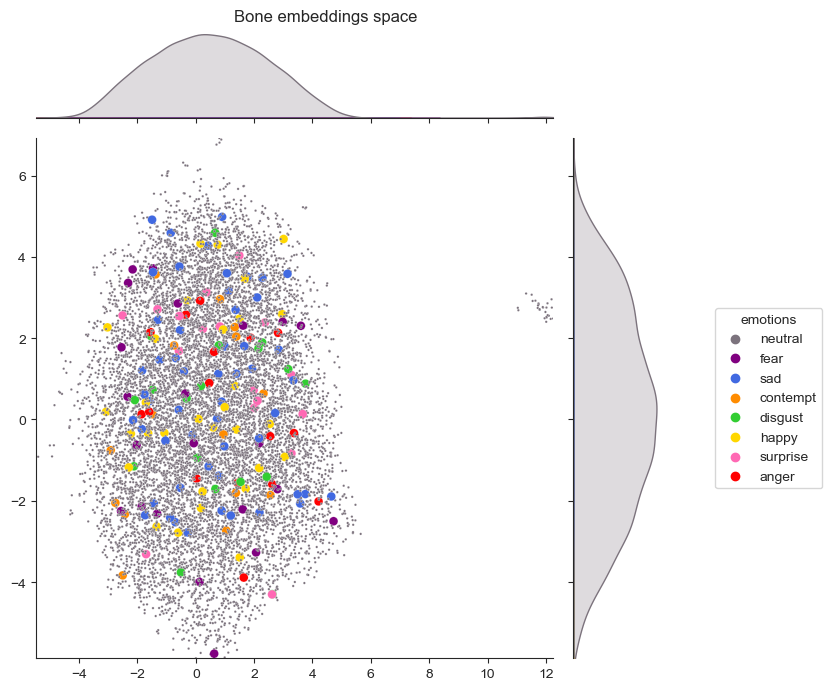

In [9]:
emotion_color_map = {
    'neutral': '#7C737D',  # Grigio chiaro
    'happy': '#FFD700',    # Oro
    'sad': '#4169E1',      # Blu reale
    'surprise': '#FF69B4', # Rosa caldo
    'fear': '#800080',     # Viola
    'disgust': '#32CD32',  # Verde lime
    'anger': '#FF0000',    # Rosso
    'contempt': '#FF8C00'  # Arancione scuro
}

# Funzione per creare jointplot
def create_jointplot(data, metadata, title, scatter_size=10,legend=False, color_map=None):
    sns.set_style("ticks")
    jp = sns.jointplot(
        x=data[:,0], 
        y=data[:,1],
        data=data, 
        hue=metadata, 
        palette=color_map,
        height=7, 
        marginal_kws=dict(fill=True),
        joint_kws={'s': scatter_size},
        legend=legend
    )
    jp.figure.suptitle(title)
    jp.figure.tight_layout()
    jp.ax_joint.set_xlim(proj_2d[:,0].min(),proj_2d[:,0].max())
    jp.ax_joint.set_ylim(proj_2d[:,1].min(),proj_2d[:,1].max())
    jp.figure.subplots_adjust(top=0.95)  # Adatta il titolo

    
    
    # Rimuovere i nomi degli assi
    jp.set_axis_labels('', '')
    # Sposta la legenda fuori dal grafico
    jp.ax_joint.legend(loc='center left', bbox_to_anchor=(1.3, 0.5), title='emotions')
    return jp

# Creare la visualizzazione UMAP
plt.figure(figsize=(15, 5))
joint_plot = create_jointplot(proj_2d, emotion_labels, 'Bone embeddings space', scatter_size=size_p, legend=labels_names[1:], color_map=emotion_color_map)

# Salva il plot come file PNG

joint_plot.savefig('./imgs/plot_umap_bone_emotion_cosine.png', bbox_inches='tight')

# Mostra il plot
plt.show()

# joint motion space 

In [10]:
data = torch.load(joint_motion_emb, map_location=torch.device('cpu'))
embedding_space = data['embeddings']

labels = []
tensor_data = []
# save label and tensor
for k in embedding_space.keys():
    l, vec = embedding_space[k].values()
    labels.append(l)
    tensor_data.append(vec)

In [11]:
# we need to convert to numpy data with shape (#_of_sample, 256)

np_data = np.array([t.numpy() for t in tensor_data]).squeeze(1)
np_data.shape

(10878, 256)

In [12]:
umap_2d = UMAP(n_components=2, min_dist=0.99, metric='cosine')

proj_2d = umap_2d.fit_transform(np_data)

In [13]:
# try to display where the emotion label are 
EMOTION_LABEL_PATH = "/homes/nrossi/code/SLR_Sentiment_Enhanced/DAN_module/sign_emotion_assosiation.json"
labels_names = ['neutral','happy', 'sad', 'surprise', 'fear', 'disgust', 'anger', 'contempt']

f_w_to_e = open(EMOTION_LABEL_PATH)
w_to_e = json.load(f_w_to_e)

raw_label = {}
for k, i in w_to_e.items():
    print(k,i)
    raw_label[labels_names[int(k)]] = i

1 [62, 157, 1118, 1511, 1855]
2 [111, 175, 317, 327, 698, 1157, 1367, 1699, 1277]
3 [1004, 769, 1299]
4 [692, 1291, 441, 628]
5 [484, 492, 1373]
6 [637, 1897, 794]
7 [309, 81]


In [14]:
# save emotion labels and size of the points 
emotion_labels = []
for l in labels:
    for k,v in raw_label.items():
        flag = False
        if int(l) in v:
            emotion_labels.append(k)
            flag = True
            break
    if not flag:
        emotion_labels.append('neutral')

size_p = []
for label,vec in zip(emotion_labels,proj_2d):
    if label != 'neutral':
        size_p.append(40)
    else:
        size_p.append(3)


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


<Figure size 1500x500 with 0 Axes>

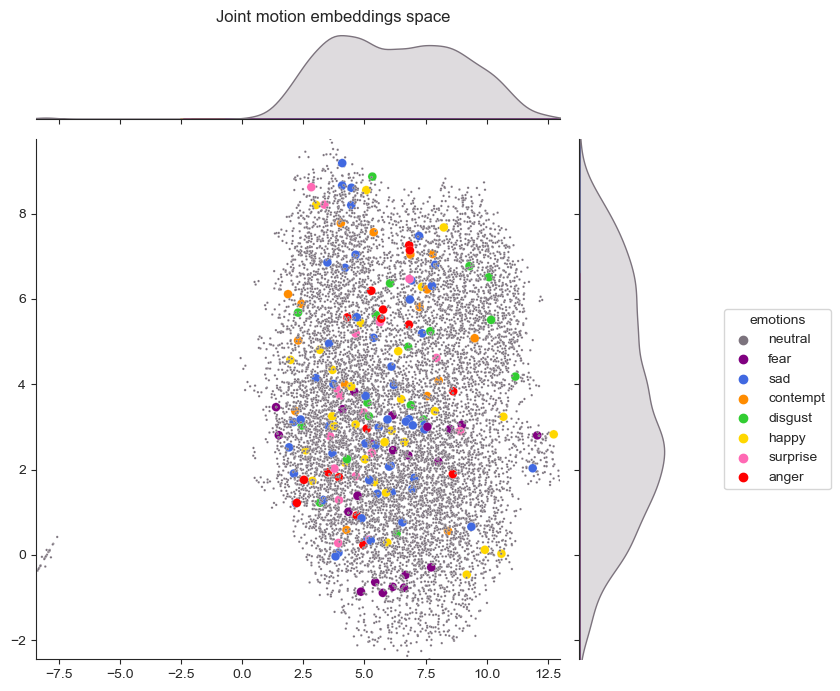

In [15]:
emotion_color_map = {
    'neutral': '#7C737D',  # Grigio chiaro
    'happy': '#FFD700',    # Oro
    'sad': '#4169E1',      # Blu reale
    'surprise': '#FF69B4', # Rosa caldo
    'fear': '#800080',     # Viola
    'disgust': '#32CD32',  # Verde lime
    'anger': '#FF0000',    # Rosso
    'contempt': '#FF8C00'  # Arancione scuro
}

# Funzione per creare jointplot
def create_jointplot(data, metadata, title, scatter_size=10,legend=False, color_map=None):
    sns.set_style("ticks")
    jp = sns.jointplot(
        x=data[:,0], 
        y=data[:,1],
        data=data, 
        hue=metadata, 
        palette=color_map,
        height=7, 
        marginal_kws=dict(fill=True),
        joint_kws={'s': scatter_size},
        legend=legend
    )
    jp.figure.suptitle(title)
    jp.figure.tight_layout()
    jp.ax_joint.set_xlim(proj_2d[:,0].min(),proj_2d[:,0].max())
    jp.ax_joint.set_ylim(proj_2d[:,1].min(),proj_2d[:,1].max())
    jp.figure.subplots_adjust(top=0.95)  # Adatta il titolo

    
    
    # Rimuovere i nomi degli assi
    jp.set_axis_labels('', '')
    # Sposta la legenda fuori dal grafico
    jp.ax_joint.legend(loc='center left', bbox_to_anchor=(1.3, 0.5), title='emotions')
    return jp

# Creare la visualizzazione UMAP
plt.figure(figsize=(15, 5))
joint_plot = create_jointplot(proj_2d, emotion_labels, 'Joint motion embeddings space', scatter_size=size_p, legend=labels_names[1:], color_map=emotion_color_map)

# Salva il plot come file PNG

joint_plot.savefig('./imgs/plot_umap_joint_motion_emotion_cosine.png', bbox_inches='tight')

# Mostra il plot
plt.show()

# Bone motion space

In [16]:
data = torch.load(bone_motion_emb, map_location=torch.device('cpu'))
embedding_space = data['embeddings']

labels = []
tensor_data = []
# save label and tensor
for k in embedding_space.keys():
    l, vec = embedding_space[k].values()
    labels.append(l)
    tensor_data.append(vec)

In [17]:
# we need to convert to numpy data with shape (#_of_sample, 256)

np_data = np.array([t.numpy() for t in tensor_data]).squeeze(1)
np_data.shape

(10878, 256)

In [18]:
umap_2d = UMAP(n_components=2, min_dist=0.99, metric='cosine')

proj_2d = umap_2d.fit_transform(np_data)

In [19]:
# try to display where the emotion label are 
EMOTION_LABEL_PATH = "/homes/nrossi/code/SLR_Sentiment_Enhanced/DAN_module/sign_emotion_assosiation.json"
labels_names = ['neutral','happy', 'sad', 'surprise', 'fear', 'disgust', 'anger', 'contempt']

f_w_to_e = open(EMOTION_LABEL_PATH)
w_to_e = json.load(f_w_to_e)

raw_label = {}
for k, i in w_to_e.items():
    print(k,i)
    raw_label[labels_names[int(k)]] = i

1 [62, 157, 1118, 1511, 1855]
2 [111, 175, 317, 327, 698, 1157, 1367, 1699, 1277]
3 [1004, 769, 1299]
4 [692, 1291, 441, 628]
5 [484, 492, 1373]
6 [637, 1897, 794]
7 [309, 81]


In [20]:
# save emotion labels and size of the points 
emotion_labels = []
for l in labels:
    for k,v in raw_label.items():
        flag = False
        if int(l) in v:
            emotion_labels.append(k)
            flag = True
            break
    if not flag:
        emotion_labels.append('neutral')

size_p = []
for label,vec in zip(emotion_labels,proj_2d):
    if label != 'neutral':
        size_p.append(40)
    else:
        size_p.append(3)


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


<Figure size 1500x500 with 0 Axes>

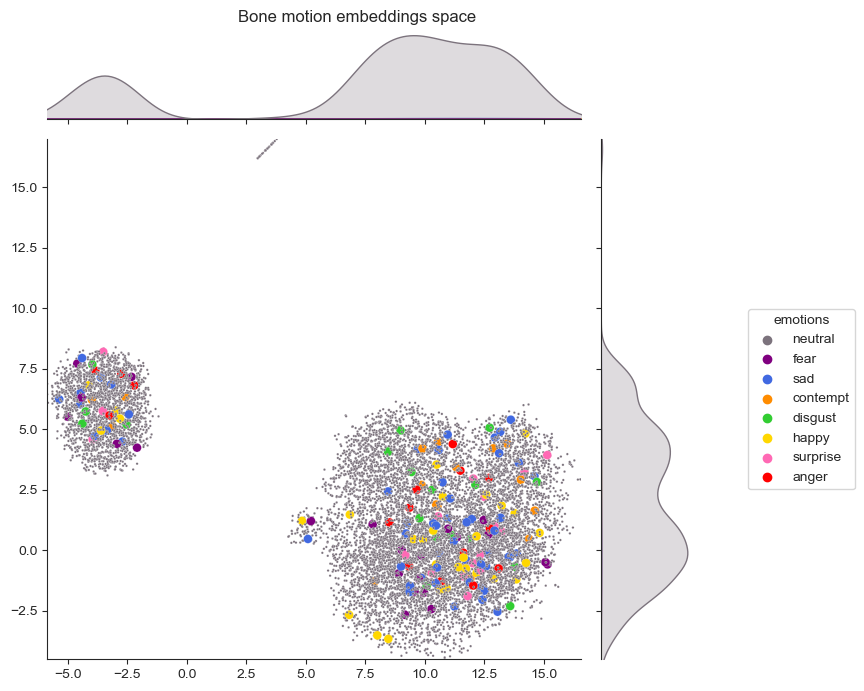

In [21]:
emotion_color_map = {
    'neutral': '#7C737D',  # Grigio chiaro
    'happy': '#FFD700',    # Oro
    'sad': '#4169E1',      # Blu reale
    'surprise': '#FF69B4', # Rosa caldo
    'fear': '#800080',     # Viola
    'disgust': '#32CD32',  # Verde lime
    'anger': '#FF0000',    # Rosso
    'contempt': '#FF8C00'  # Arancione scuro
}

# Funzione per creare jointplot
def create_jointplot(data, metadata, title, scatter_size=10,legend=False, color_map=None):
    sns.set_style("ticks")
    jp = sns.jointplot(
        x=data[:,0], 
        y=data[:,1],
        data=data, 
        hue=metadata, 
        palette=color_map,
        height=7, 
        marginal_kws=dict(fill=True),
        joint_kws={'s': scatter_size},
        legend=legend
    )
    jp.figure.suptitle(title)
    jp.figure.tight_layout()
    jp.ax_joint.set_xlim(proj_2d[:,0].min(),proj_2d[:,0].max())
    jp.ax_joint.set_ylim(proj_2d[:,1].min(),proj_2d[:,1].max())
    jp.figure.subplots_adjust(top=0.95)  # Adatta il titolo

    
    
    # Rimuovere i nomi degli assi
    jp.set_axis_labels('', '')
    # Sposta la legenda fuori dal grafico
    jp.ax_joint.legend(loc='center left', bbox_to_anchor=(1.3, 0.5), title='emotions')
    return jp

# Creare la visualizzazione UMAP
plt.figure(figsize=(15, 5))
joint_plot = create_jointplot(proj_2d, emotion_labels, 'Bone motion embeddings space', scatter_size=size_p, legend=labels_names[1:], color_map=emotion_color_map)

# Salva il plot come file PNG

joint_plot.savefig('./imgs/plot_umap_bone_motion_emotion_cosine.png', bbox_inches='tight')

# Mostra il plot
plt.show()